In [1]:
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from utils.functions import *

from models.CNN.cnn import CNN
from models.RNN.rnn import RNN
from models.Transformer.classifier import Transformer 

from torch.utils.data import Dataset, DataLoader

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

In [2]:
SEED = 777

set_seed(SEED)

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

if device == torch.device('cuda'):
    print(torch.cuda.get_device_name())

NVIDIA GeForce RTX 3090


In [4]:
train = pd.read_csv('./dataset/train.csv')
test = pd.read_csv('./dataset/test.csv')

In [5]:
int2char = {key: value for key, value in enumerate(train['감정_대분류'].unique())}
char2int = {key: value for value, key in enumerate(train['감정_대분류'].unique())}

In [6]:
char2int

{'불안': 0, '기쁨': 1, '분노': 2, '슬픔': 3, '상처': 4, '당황': 5}

In [7]:
train['감정_대분류'] = [char2int[i] for i in train['감정_대분류']]

In [8]:
train # '감정_대분류' 인코딩 확인

,성별,감정_대분류,사람문장1,사람문장2
0,남성,0,당뇨랑 합병증 때문에 먹어야 할 약이 열 가지가 넘어가니까 스트레스야.,건강할 때 관리 좀 잘할걸 하는 생각이 들더라고.
1,남성,1,재취업이 돼서 받게 된 첫 월급으로 온 가족이 외식을 할 예정이야. 너무 행복해.,퇴직 후 다시는 돈을 못 벌 줄 알았는데 이렇게 월급으로 가족에게 맛있는 밥을 살 ...
2,여성,1,빚을 드디어 다 갚게 되어서 이제야 안도감이 들어.,빚도 다 갚았으니 당분간은 아무 생각도 안 하며 살고 싶어.
3,남성,2,이제 돈이라면 지긋지긋해.,나이가 예순이 넘으니 돈이 나갈 데도 많고 힘드네.
4,여성,3,친구 때문에 눈물 나.,내 친구가 나한테 거짓말했어.
...,...,...,...,...
10744,남성,4,회사에 남아서 일을 더 하고 싶었는데 권고사직을 당해버렸어.,난 아직도 충분히 더 일할 능력이 있다고 생각했는데 나의 착각이었나 봐.
10745,남성,0,나이가 들어서 그런지 갑자기 아무것도 보이지 않다가 다시 시력이 돌아왔어.,정말 깜짝 놀랐어. 이럴 때 나이가 들었다는 걸 실감해서 너무 불안해.
10746,남성,5,아이고 이거 큰일이네.,하나밖에 없는 딸아이 결혼식이 다음 달인데 병원에서 입원하라는데?
10747,여성,3,내가 나이가 들어 죽을 때가 되니까 자식들에게 이제야 연락이 와서 나를 챙기는 것 같아.,내 자식들은 그냥 내가 남길 돈만 생각하는 것 같아.


In [9]:
train_df = train.sample(frac=0.8, random_state=777).reset_index() # 전체 데이터셋의 80%를 학습 데이터로 사용
valid_df = train.drop(train_df.index).reset_index()

In [10]:
valid_df

,index,성별,감정_대분류,사람문장1,사람문장2
0,8599,남성,5,노인정에 갔는데 다들 자식 자랑에 바쁘더라고. 난 거기서 겉돌기만 하니 외로워.,아들이 집을 사 줬다느니 딸이 명품을 사 줬다느니 자랑하는데 할 말도 없고 당황스럽...
1,8600,남성,0,녹내장 때문에 밤에 눈이 보이지 않아 활동을 할 수 없는 것이 안타까워.,녹내장뿐만 아니라 눈이 점점 취약해지는 것이 불안하게 하는 것 같아.
2,8601,남성,5,체력이 부족해서 아내에게 같이 운동을 하자고 하는데 한 번도 하지 않으니 답답해.,체력이 모자라서 함께 운동하자는데 자기는 필요 없다고 하니 당황스럽더라고.
3,8602,남성,0,요새 코로나 때문에 외국에서 유학 중인 아이들이 걱정돼.,외국에 있다가 코로나에 걸리면 치료도 늦는다고 하더라고.
4,8603,남성,4,벼룩의 간을 빼지!,며칠 후에 입원을 해야 하는데\n급하다 해서 병원비를 빌려줬더니 함흥차사야.
...,...,...,...,...,...
2145,10744,남성,4,회사에 남아서 일을 더 하고 싶었는데 권고사직을 당해버렸어.,난 아직도 충분히 더 일할 능력이 있다고 생각했는데 나의 착각이었나 봐.
2146,10745,남성,0,나이가 들어서 그런지 갑자기 아무것도 보이지 않다가 다시 시력이 돌아왔어.,정말 깜짝 놀랐어. 이럴 때 나이가 들었다는 걸 실감해서 너무 불안해.
2147,10746,남성,5,아이고 이거 큰일이네.,하나밖에 없는 딸아이 결혼식이 다음 달인데 병원에서 입원하라는데?
2148,10747,여성,3,내가 나이가 들어 죽을 때가 되니까 자식들에게 이제야 연락이 와서 나를 챙기는 것 같아.,내 자식들은 그냥 내가 남길 돈만 생각하는 것 같아.


In [11]:
train_sentences, train_label = encode_data(train_df)
valid_sentences, valid_label = encode_data(valid_df)
test_sentences, test_label = encode_data(test)

In [12]:
class EmotionDataset(Dataset):
    def __init__(self, sentence, label, mode=None):
        self.sentence = sentence
        self.label = label
        self.mode = mode
        self.max_len = 152
        
    def __len__(self):
        return len(self.label)
    
    def __getitem__(self, idx):
        sentence_item = self.sentence[idx]
        label_item = self.label[idx]

        if len(sentence_item) < self.max_len:
            sentence_item += (self.max_len-len(sentence_item))*[2]
        elif len(sentence_item) > self.max_len:
            sentence_item = sentence_item[:self.max_len-1] + [1]
            
        if self.mode == 'train':
            return torch.LongTensor(sentence_item), label_item
        else:
            return torch.LongTensor(sentence_item)

In [13]:
train_dataset = EmotionDataset(train_sentences, train_label, mode='train')
valid_dataset = EmotionDataset(valid_sentences, valid_label, mode='train')
test_dataset = EmotionDataset(test_sentences, test_label, mode='test')

train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True)
valid_dataloader = DataLoader(valid_dataset, batch_size=16, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=16, shuffle=False)

## 공통 하이퍼파라미터

In [14]:
LR = 0.001
EPOCHS = 80
DROPOUT = 0.5
NUM_CLASS = 6
EMBED_DIM = 100
DEVICE = device
VOCAB_SIZE = 9735

## CNN

In [15]:
N_FILTERS = [20, 20, 20]
FILTER_SIZE = [2, 3, 4]

In [16]:
cnn = CNN(VOCAB_SIZE, EMBED_DIM, N_FILTERS, FILTER_SIZE, DROPOUT, NUM_CLASS)

In [17]:
cnn

CNN(
  (embedding): Embedding(9735, 100)
  (conv1d_layers): ModuleList(
    (0): Conv1d(100, 20, kernel_size=(2,), stride=(1,))
    (1): Conv1d(100, 20, kernel_size=(3,), stride=(1,))
    (2): Conv1d(100, 20, kernel_size=(4,), stride=(1,))
  )
  (fc_layer): Linear(in_features=60, out_features=6, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)

In [17]:
optimizer = optim.AdamW(cnn.parameters(), lr=LR, weight_decay=1e-2)

In [18]:
cnn_train_loss, cnn_valid_loss = train_model(cnn, optimizer, train_dataloader, valid_dataloader, EPOCHS, DEVICE)

Start Training ...


 Epoch  |  Train Loss  |  Val Loss  |  Val Acc 
------------------------------------------------
   1    |   1.770934   |  1.434435  |   50.96   
   2    |   1.486955   |  1.234439  |   59.48   
   3    |   1.333173   |  1.080661  |   65.68   
   4    |   1.200237   |  0.968861  |   69.78   
   5    |   1.092784   |  0.873244  |   73.50   
   6    |   1.006004   |  0.803054  |   76.23   
   7    |   0.931838   |  0.730732  |   79.27   
   8    |   0.861415   |  0.670603  |   80.62   
   9    |   0.804022   |  0.630972  |   82.56   
  10    |   0.751083   |  0.588147  |   83.43   
  11    |   0.711904   |  0.551633  |   84.88   
  12    |   0.656744   |  0.526022  |   85.20   
  13    |   0.610176   |  0.503019  |   85.88   
  14    |   0.589512   |  0.479252  |   86.81   
  15    |   0.550384   |  0.450765  |   87.87   
  16    |   0.523515   |  0.443288  |   87.93   
  17    |   0.504884   |  0.426429  |   88.29   
  18    |   0.470483   |  0.413268  |   89.35   


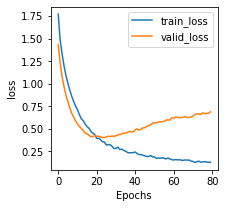

In [19]:
total_train_loss = np.array(cnn_train_loss)
total_valid_loss = np.array(cnn_valid_loss)

plt.figure(figsize = (3,3))

plt.plot(total_train_loss, label="train_loss")
plt.plot(total_valid_loss, label="valid_loss")

plt.xlabel("Epochs")
plt.ylabel("loss")

plt.legend(loc='best')

plt.show()

In [20]:
cnn_preds = make_prediction(cnn, test_dataloader, DEVICE)

In [21]:
cnn_preds = [int2char[i] for i in cnn_preds]

In [22]:
cnn_cnt = 0

for prediction, answer in zip(cnn_preds, test['감정_대분류'].tolist()):
    if prediction == answer:
        cnn_cnt += 1

In [23]:
print(f'>> 테스트 데이터 개수: {len(test_sentences)}개')
print(f'>> 정답 개수: {cnn_cnt}개')
print(f'>> 정확도: {round(cnn_cnt/len(test_sentences)*100, 2)}%')

>> 테스트 데이터 개수: 725개
>> 정답 개수: 453개
>> 정확도: 62.48%


## RNN

In [18]:
HIDDEN_DIM = 150
N_LAYERS = 2

In [19]:
rnn = RNN(VOCAB_SIZE, EMBED_DIM, HIDDEN_DIM, N_LAYERS, DROPOUT, NUM_CLASS, DEVICE)

In [20]:
rnn

RNN(
  (embed): Embedding(9735, 100)
  (dropout): Dropout(p=0.5, inplace=False)
  (gru): GRU(100, 150, num_layers=2, batch_first=True)
  (linear_layer): Linear(in_features=150, out_features=6, bias=True)
)

In [26]:
optimizer = optim.AdamW(rnn.parameters(), lr=LR, weight_decay=1e-2)

In [27]:
rnn_train_loss, rnn_valid_loss = train_model(rnn, optimizer, train_dataloader, valid_dataloader, EPOCHS, DEVICE)

Start Training ...


 Epoch  |  Train Loss  |  Val Loss  |  Val Acc 
------------------------------------------------
   1    |   1.800246   |  1.792120  |   16.70   
   2    |   1.789712   |  1.744622  |   24.61   
   3    |   1.599114   |  1.354089  |   44.07   
   4    |   1.282946   |  1.129895  |   56.19   
   5    |   1.071157   |  0.950051  |   66.60   
   6    |   0.851692   |  0.738954  |   76.40   
   7    |   0.654703   |  0.647263  |   79.98   
   8    |   0.493026   |  0.542104  |   84.65   
   9    |   0.367799   |  0.508986  |   86.73   
  10    |   0.292738   |  0.489268  |   87.78   
  11    |   0.227778   |  0.502959  |   88.01   
  12    |   0.191833   |  0.508285  |   89.35   
  13    |   0.146004   |  0.541494  |   88.98   
  14    |   0.143429   |  0.498110  |   89.17   
  15    |   0.116499   |  0.576597  |   89.58   
  16    |   0.103156   |  0.592785  |   89.81   
  17    |   0.110463   |  0.546414  |   89.58   
  18    |   0.093030   |  0.617928  |   88.89   


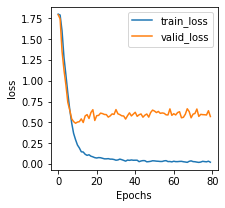

In [28]:
total_train_loss = np.array(rnn_train_loss)
total_valid_loss = np.array(rnn_valid_loss)

plt.figure(figsize = (3,3))

plt.plot(total_train_loss, label="train_loss")
plt.plot(total_valid_loss, label="valid_loss")

plt.xlabel("Epochs")
plt.ylabel("loss")

plt.legend(loc='best')

plt.show()

In [29]:
rnn_preds = make_prediction(rnn, test_dataloader, device)

In [30]:
rnn_preds = [int2char[i] for i in rnn_preds]

In [31]:
rnn_cnt = 0

for prediction, answer in zip(rnn_preds, test['감정_대분류'].tolist()):
    if prediction == answer:
        rnn_cnt += 1

In [32]:
print(f'>> 테스트 데이터 개수: {len(test_sentences)}개')
print(f'>> 정답 개수: {rnn_cnt}개')
print(f'>> 정확도: {round(rnn_cnt/len(test_sentences)*100, 2)}%')

>> 테스트 데이터 개수: 725개
>> 정답 개수: 463개
>> 정확도: 63.86%


## Transformer

In [33]:
N_LAYER = 1
D_MODEL = 152

In [34]:
transformer = Transformer(VOCAB_SIZE, D_MODEL, N_LAYER, NUM_CLASS)

In [35]:
optimizer = optim.AdamW(transformer.parameters(), lr=LR, weight_decay=1e-2)

In [36]:
transformer_train_loss, transformer_valid_loss = train_model(transformer, optimizer, train_dataloader, valid_dataloader, EPOCHS, DEVICE)

Start Training ...


 Epoch  |  Train Loss  |  Val Loss  |  Val Acc 
------------------------------------------------
   1    |   1.767608   |  1.687552  |   32.92   
   2    |   1.669078   |  1.570131  |   45.35   
   3    |   1.615919   |  1.571580  |   45.88   
   4    |   1.601725   |  1.544321  |   48.50   
   5    |   1.588428   |  1.538263  |   49.15   
   6    |   1.579076   |  1.519912  |   50.99   
   7    |   1.567316   |  1.510935  |   51.98   
   8    |   1.565632   |  1.496451  |   53.64   
   9    |   1.555237   |  1.486326  |   54.65   
  10    |   1.542179   |  1.494595  |   54.27   
  11    |   1.540560   |  1.476727  |   55.80   
  12    |   1.538031   |  1.476561  |   55.80   
  13    |   1.535238   |  1.463634  |   57.38   
  14    |   1.522454   |  1.466610  |   57.07   
  15    |   1.518361   |  1.451118  |   58.43   
  16    |   1.509290   |  1.446378  |   58.75   
  17    |   1.498203   |  1.434110  |   60.45   
  18    |   1.493905   |  1.441078  |   59.20   


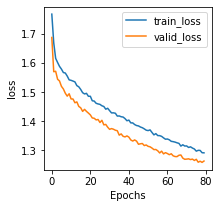

In [37]:
total_train_loss = np.array(transformer_train_loss)
total_valid_loss = np.array(transformer_valid_loss)

plt.figure(figsize = (3,3))

plt.plot(total_train_loss, label="train_loss")
plt.plot(total_valid_loss, label="valid_loss")

plt.xlabel("Epochs")
plt.ylabel("loss")

plt.legend(loc='best')

plt.show()

In [38]:
transformer_preds = make_prediction(transformer, test_dataloader, device)

In [39]:
transformer_preds = [int2char[i] for i in transformer_preds]

In [40]:
transformer_cnt = 0

for prediction, answer in zip(transformer_preds, test['감정_대분류'].tolist()):
    if prediction == answer:
        transformer_cnt += 1

In [41]:
print(f'>> 테스트 데이터 개수: {len(test_sentences)}개')
print(f'>> 정답 개수: {transformer_cnt}개')
print(f'>> 정확도: {round(transformer_cnt/len(test_sentences)*100, 2)}%')

>> 테스트 데이터 개수: 725개
>> 정답 개수: 477개
>> 정확도: 65.79%


## 결과 저장

In [42]:
test.insert(2, 'CNN_예측', cnn_preds)
test.insert(3, 'RNN_예측', rnn_preds)
test.insert(4, 'Transformer_예측', transformer_preds)

In [43]:
test

,성별,감정_대분류,CNN_예측,RNN 예측,Transformer 예측,사람문장1,사람문장2
0,남성,기쁨,당황,기쁨,당황,지금까지 모은 돈으로 사업하기로 했어. 감개무량해.,응. 평생 월급만 받고 살았다가 사업을 하려고 하니 떨리기도 해.
1,남성,상처,분노,분노,불안,이번에 새로 들어온 상사가 자꾸 내가 하는 일마다 참견을 하네. 너무 스트레스 받아.,잘 모르겠어. 지금은 그 사람과 말도 하기 싫어.
2,여성,상처,상처,상처,상처,자식들에게 희생하면서 살아왔던 것 같아.,요즘 나이 들면서 혼자 있는 시간이 많다보니까 외로워서 그러는 것 같아.
3,남성,상처,분노,상처,상처,아들 수술비 마련하려면 돈을 벌어야 하는데 일을 구하기가 너무 어려워.,내가 만성질환을 앓고 있어서 사람들이 날 안 써줘.
4,여성,기쁨,기쁨,기쁨,기쁨,건강해서 편안해.,응. 다 나았어.
...,...,...,...,...,...,...,...
720,여성,슬픔,슬픔,상처,슬픔,동서는 서방님 병문안 갈 때마다 병원비 좀 보태 달라고 해.,우리 가족도 금전적 여유가 없는데 자꾸 보태 달라고 하니. 우리 입장도 곤란한 걸 ...
721,여성,슬픔,슬픔,슬픔,슬픔,투자했던 기업의 주가가 떨어졌어.,실망스럽고 그 기업 주가가 왜 떨어졌는지를 모르겠어.
722,여성,불안,불안,불안,불안,폐결핵은 이미 완치된 것 같은데 약을 한 달이나 더 먹으라고 하네? 아직 안 나은 ...,이대로 혹시 더 심해져서 죽게 되는 건 아닐까?
723,남성,분노,슬픔,불안,불안,은행 대출이 막혀서 생활비를 구할 수가 없어. 이제 어떻게 살아야 하나 막막해.,당장 내일 밥은 어떡하고 내 병원비는 어쩌지.


In [44]:
test.to_csv('./dataset/result.csv', index=False, encoding='utf-8-sig')